In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
import os
import pickle
import sys

from konlpy.tag import Kkma, Okt
import gc

import re
from sklearn.feature_extraction.text import CountVectorizer

from collections import defaultdict

from ksenticnet_kaist import *

ksenticnet = get_ksenticnet()

keys = list(ksenticnet.keys())
senticvals = [[float(i) for i in val[:4]] for val in  ksenticnet.values()]
sentiments = []
polarity = []
semantics = []
for key, val in ksenticnet.items():
    for i in val[4:]:
        if i in ['positive', 'negative']:
            polar_ind = val.index(i)
            sentiments.append(val[4 : polar_ind])
            polarity.append(val[polar_ind : polar_ind+2])
            semantics.append(val[polar_ind+2 :])
            break

ksenticnets = defaultdict(dict)
for key, val, senti, p, seman in zip(keys, 
                                     senticvals, 
                                     sentiments, 
                                     polarity, 
                                     semantics):
    ksenticnets[key]['sentic_value'] = val
    ksenticnets[key]['sentiment'] = senti
    ksenticnets[key]['polarity'] = p
    ksenticnets[key]['semantic'] = seman

f = lambda x : [i if i > 0 else 0 for i in x]
g = lambda x : [abs(i) if i < 0 else 0 for i in x]
scores = np.array(list(map(lambda x : f(x) + g(x), senticvals)))
scores /= scores.sum(axis=1).reshape(-1, 1)

class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
MAX_VOCAB_SIZE = 50000

def sampleFromDirichlet(alpha):
    return np.random.dirichlet(alpha)

def sampleFromCategorical(theta):
    theta = theta / np.sum(theta)
    return np.random.multinomial(1, theta).argmax()

def word_indices(wordOccurenceVec):
    for idx in wordOccurenceVec.nonzero()[0]:
        for i in range(int(wordOccurenceVec[idx])):
            yield idx
            
class KSenticNet():
    keys = {j : i for i, j in  enumerate(keys)}
    scores = scores
    
class SentimentLDAGibbsSampler:
    
    def __init__(self, numTopics, alpha, beta, gamma, numSentiments=2):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.numTopics = numTopics
        self.numSentiments = numSentiments
        
    def processSingleReview(self, review, st, d=None, stopwords=None):
        letters_only = re.sub('[^ㄱ-하-ㅣ가-힣]', ' ', review).strip()
        if not stopwords:
            stops = list('의가이은을로들는좀잘걍과도를자에와한것') + ['으로', '하다']
        else:
            stops = stopwords
        words = st.morphs(letters_only, stem=True, norm=True)
        meaningful_words = [w for w in words if w not in stops]
        return ' '.join(meaningful_words)
    
    def processReviews(self, reviews, st, saveAs=None, saveOverride=False, 
                       do_preprocess=True, return_processed_review=False):
        import os
        import dill
        if not saveOverride and saveAs and os.path.isfile(saveAs):
            [wordOccurenceMatrix, self.vectorizer] = dill.load(open(saveAs, 'r'))
            return wordOccurenceMatrix
        if do_preprocess:
            processed_reviews = []
            for i, review in enumerate(reviews):
                if (i + 1) % 10000 == 0:
                    print(' Review {} of {}'.format(i + 1, len(reviews)))
                processed_reviews.append(self.processSingleReview(review, st, i))
        else:
            processed_reviews = reviews
        if return_processed_review:
            return processed_reviews
        self.vectorizer = CountVectorizer(analyzer='word',
                                          tokenizer=None,
                                          preprocessor=None,
                                          max_features=MAX_VOCAB_SIZE)
        train_data_features = self.vectorizer.fit_transform(processed_reviews)
        wordOccurenceMatrix = train_data_features
        if saveAs:
            dill.dump([wordOccurenceMatrix, self.vectorizer], open(saveAs, 'w'))
        return wordOccurenceMatrix
    
    def _initialize_(self, reviews, st, saveAs=None, saveOverride=False, do_preprocess=True):
        self.wordOccurenceMatrix = self.processReviews(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        
        # Pseudocounts
        self.n_dt = np.zeros((numDocs, self.numTopics))
        self.n_dts = np.zeros((numDocs, self.numTopics, self.numSentiments))
        self.n_d = np.zeros((numDocs))
        self.n_vts = np.zeros((vocabSize, self.numTopics, self.numSentiments))
        self.n_ts = np.zeros((self.numTopics, self.numSentiments))
        self.topics = {}
        self.sentiments = {}
        self.priorSentiment = {}
        
        alphaVec = self.alpha * np.ones(self.numTopics)
        gammaVec = self.gamma * np.ones(self.numSentiments)
        
        print('--* KSenticNet으로 사전 확률 조작 중... *--')
        # 감정 사전 (KSenticNEt)을 사용하여 사전 확률을 조작 중.
        for i, word in enumerate(self.vectorizer.get_feature_names()):
            w = KSenticNet.keys.get(word)
            if not w: continue
            synsets = KSenticNet.scores[w, :]
            self.priorSentiment[i] = np.random.choice(self.numSentiments, p=synsets)
        
        print('--* initialize 작업 진행 중... *--')
        for d in range(numDocs):
            if d % 5000 == 0: print(' Doc {} of {} Reviews'.format(d, numDocs))
            topicDistribution = sampleFromDirichlet(alphaVec)
            sentimentDistribution = np.zeros((self.numTopics, self.numSentiments))
            for t in range(self.numTopics):
                sentimentDistribution[t, :] = sampleFromDirichlet(gammaVec)
            for i, w in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                t = sampleFromCategorical(topicDistribution)
                s = sampleFromCategorical(sentimentDistribution[t, :])
                
                self.topics[(d, i)] = t
                self.sentiments[(d, i)] = s
                self.n_dt[d, t] += 1
                self.n_dts[d, t, s] += 1
                self.n_d[d] += 1
                self.n_vts[w, t, s] += 1
                self.n_ts[t, s] += 1
                
    def conditionalDistribution(self, d, v):
        probabilites_ts = np.ones((self.numTopics, self.numSentiments))
        firstFactor = (self.n_dt[d] + self.alpha) / \
                (self.n_d[d] + self.numTopics * self.alpha)
        secondFactor = (self.n_dts[d, :, :] + self.gamma) / \
                (self.n_dt[d, :] + self.numSentiments * self.gamma)[:, np.newaxis]
        thirdFactor = (self.n_vts[v, :, :] + self.beta) / \
                (self.n_ts + self.n_vts.shape[0] * self.beta)
        probabilites_ts *= firstFactor[:, np.newaxis]
        probabilites_ts *= secondFactor * thirdFactor
        probabilites_ts /= np.sum(probabilites_ts)
        return probabilites_ts
                
    def run(self, reviews, st, maxIters=30, saveAs=None, saveOverride=False, do_preprocess=True):
        self._initialize_(reviews, st, saveAs, saveOverride, do_preprocess)
        numDocs, vocabSize = self.wordOccurenceMatrix.shape
        for iteration in range(maxIters):
            gc.collect()
            print('Starting iteration {} of {}'.format(iteration + 1, maxIters))
            for d in range(numDocs):
                for i, v in enumerate(word_indices(self.wordOccurenceMatrix[d, :].toarray()[0])):
                    t = self.topics[(d, i)]
                    s = self.sentiments[(d, i)]
                    self.n_dt[d, t] -= 1
                    self.n_d[d] -= 1
                    self.n_dts[d, t, s] -= 1
                    self.n_vts[v, t, s] -= 1
                    self.n_ts[t, s] -= 1
                    
                    probabilites_ts = self.conditionalDistribution(d, v)
                    if v in self.priorSentiment:
                        s = self.priorSentiment[v]
                        t = sampleFromCategorical(probabilites_ts[:, s])
                    else:
                        ind = sampleFromCategorical(probabilites_ts.flatten())
                        t, s = np.unravel_index(ind, probabilites_ts.shape)
                    
                    self.topics[(d, i)] = t
                    self.sentiments[(d, i)] = s
                    self.n_dt[d, t] += 1
                    self.n_d[d] += 1
                    self.n_dts[d, t, s] += 1
                    self.n_vts[v, t, s] += 1
                    self.n_ts[t, s] += 1
        print('Done.')

In [2]:
# 데이터 호출 (spacing 전처리 수행 o)
df2 = pd.read_csv('spacing_nsmc_data.csv')

In [3]:
# 감정 분류 호출
with open('1st_jst_result.pkl', 'rb') as f:
    JST = pickle.load(f)

In [4]:
df2.loc[0, 'review']

'전체 관람가는 아닌 것 같아요'

In [5]:
JST.n_dts[0]

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])

In [11]:
res = defaultdict(list)
for i, j in JST.sentiments.items():
    res[i[0]].append(j)

from collections import Counter
res = {i : Counter(j) for i, j in res.items()}

i2senti = {0 : 'joy', 1 : 'interest', 2 : 'anger', 3 : 'admiration',
           4 : 'sadness', 5 : 'surprise', 6 : 'fear', 7 : 'disgust'}

In [12]:
senti_label_each_review = [[] for _ in range(len(df2))]
for i in range(len(df2)):
    if res.get(i):
        for j in res.get(i).most_common(2):
            senti_label_each_review[i].append(i2senti[j[0]])
    else:
        senti_label_each_review[i].append(['neutral'])

In [13]:
X_train = df2['review'].copy()
y_train = senti_label_each_review

In [14]:
from konlpy.tag import Okt
okt = Okt()
def tokenizer_morphs(doc):
    return okt.morphs(doc)

C:\ProgramData\Anaconda3\envs\keras\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [16]:
X_train2 = np.array(X_train.values)
y_train2 = np.array([i[0] for i in y_train])

y_label = np.zeros((len(y_train), len(i2senti.values())))
senti2i = {j : i for i, j in i2senti.items()}
for ix, contents in enumerate(y_train):
    for j in contents:
        if j == ['neutral']:
            continue
        if y_label[ix, senti2i[j]] == 0:
            y_label[ix, senti2i[j]] += 1

In [17]:
ind = np.where(y_label.sum(axis=1) != 0)

In [18]:
X_train2 = X_train2[ind]
y_label = y_label[ind]
y_train2 = y_train2[ind]

In [19]:
y_train2 = list(map(lambda x : senti2i[x], y_train2[:500000]))

# 작업을 이렇게 빠르게 진행하자
- JST 성능 평가는 포기한다. (500개 정도만 대략적으로 진행, 혹은 향후 이렇게 평가할 것이다 정의)
- test index를 정의해서 앞으로 동일하게 성능을 평가한다.
- 253만개에서 데이터를 어떻게 선정할 지 기준을 정해서 table로 정리한다. (vesion 0.1)
- version 0.0은 baseline, 원래 수행한 내용을 그대로 업로드한다.

In [20]:
# 데이터 호출 (spacing 전처리 수행 o)
df2 = pd.read_csv('spacing_nsmc_data.csv')

In [21]:
d_path = 'd:/naver_review/'
review_folder = os.listdir(d_path)
t = {}
for ix, review_file in enumerate(review_folder):
    with open(d_path + review_file, 'rb') as f:
        t[ix] = json.load(f)
t1 = pd.DataFrame.from_dict(t[0])
t2 = pd.DataFrame.from_dict(t[1])
t3 = pd.DataFrame.from_dict(t[2])
t4 = pd.DataFrame.from_dict(t[3])
t5 = pd.DataFrame.from_dict(t[4])
t6 = pd.DataFrame.from_dict(t[5])

dfnew = pd.concat((t1, t2, t3, t4, t5, t6))
del t, t1, t2, t3, t4, t5, t6

In [22]:
df2[['movie_id', 'rating', 'review']].head()

,movie_id,rating,review
0,10001,10,전체 관람가는 아닌 것 같아요
1,10001,10,디렉터스 컷으로 봐서 거의 3시간 짜리인데 참 흡인력 있다
2,10001,10,태어나 처음으로 가슴 아리는 영화였다. 20년 이상 지났지만.. 생각하면 또 가슴이...
3,10001,10,어린시절 고딩 때 봤던 때랑 또 결혼하고 나서 봤을 때의 느낌은 확실히 다르네요. ...
4,10001,10,토토에게 넓은 세상을 보여주고 픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 ...


In [23]:
dfnew[['MovieCode', 'point', 'review']].head()

,MovieCode,point,review
0,182699,10.0,감동입니다.. 말이 필요 없습니다 꼭 보세요그리고 상영관을 늘려 주심 감사하겠습니다^^
1,182699,1.0,쩌네요 장관이구요 걸경입니다.
2,182699,10.0,"우리민족이 북한이 말하는 지상낙원이 아니라 생지옥, 생감옥에 지금 이시간에도 그곳..."
3,182699,10.0,북한의 현실을 보여주는 영화입니다.. 정말 이런 영화가 많이 배급되어야 합니다!
4,182699,10.0,많이 울었습니다..화도나고 속상하고.. 북한의 현실을 나라꼭대기에 앉아있는 그분과 ...


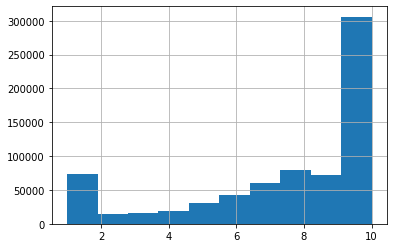

In [24]:
df2['rating'].hist()

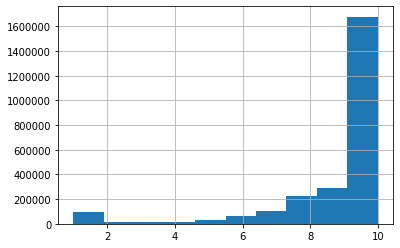

In [25]:
dfnew['point'].hist()

In [26]:
from chatspace import ChatSpace

spacer = ChatSpace()

Loading JIT Compiled ChatSpace Model


# Selenium

In [411]:
from selenium import webdriver

# Chrome의 경우 | 아까 받은 crhomedriver의 위치를 지정해준다.
driver = webdriver.Chrome('C:/research_persona/Crawler/chromedriver')
# PhantomJS의 경우 | 아까 받은 PhantomJS의 위치를 지정해준다.
# driver = webdriver.PhanhomJS()
driver.implicitly_wait(3)
# url에 접근한다.
driver.get('https://speller.cs.pusan.ac.kr/')

In [453]:
driver.find_element_by_name('text1').send_keys('나 잡아봐라앗~')

In [454]:
driver.find_element_by_id('btnCheck').click()

In [460]:
html = driver.page_source

In [252]:
from bs4 import BeautifulSoup

In [461]:
soup = BeautifulSoup(html, 'html.parser')

In [462]:
announceText = soup.find('td', {'id':'pageAnnounce'}).text

In [463]:
announceText

''

In [464]:
if announceText:
    print('dfads')

In [447]:
int(announceText.split(' ')[1].split('페이지')[0])

2

In [449]:
for i in range(1, int(announceText.split(' ')[1].split('페이지')[0])):
    print(i)

1


In [450]:
driver.find_element_by_id('nextBtn').click()

In [452]:
driver.find_element_by_id('btnRenew2').click()

In [353]:
t = soup.find('div', {"class":"divScrollbarStyle", 'id':'divLeft1'}).td

In [354]:
rule = {i.next.next_sibling : i.span.text for i in t.find_all('font')}

In [355]:
text =     '''
    과연 이것도 막을 수 있을까?
    내가 사랑한 모든 행복을 더해도 우리의 삶의 낙만 못하죠
    어떻게 잊을까요 어떻게 견뎌낼까요
    나는 기도해요 사랑이 우수운 나이 까지
    가숨이 흘러 내려 
    바라만 봐도 좋았던 나였는데
    욕심이 자라서 이렇게 벌을 받나요오오
    '''

In [357]:
rule

{'잊을까요 어떻게': '잊을까요? 어떻게',
 '기도해요 사랑이': '기도해요. 사랑이',
 '우수운': '우스운',
 '나이 까지': '나이까지',
 '가숨이': '가슴이',
 '흘러 내려': '흘러내려',
 '받나요오오': '받나요 오오'}

In [358]:
for i,j in rule.items():
    text = text.replace(i, j)

In [359]:
text

'\n    과연 이것도 막을 수 있을까?\n    내가 사랑한 모든 행복을 더해도 우리의 삶의 낙만 못하죠\n    어떻게 잊을까요? 어떻게 견뎌낼까요\n    나는 기도해요. 사랑이 우스운 나이까지\n    가슴이 흘러내려 \n    바라만 봐도 좋았던 나였는데\n    욕심이 자라서 이렇게 벌을 받나요 오오\n    '

In [299]:
[ for i in t.find_all('font')]

['아닌 것 같아요', '떠나가도', '뒤에 질래', '가슴이 온전히', '위한다 너를']

In [218]:
soup.find('div', {"class":"divScrollbarStyle", 'id':'divLeft1'}).span.text

'떠나가도'

In [465]:
driver.close()

In [171]:
reviews = np.hstack((df2['review'].values, dfnew['review'].values))

In [165]:
import time

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('\'{:s}\'  {:2.2f} ms  {:2.2f} sec  {:2.2f} min  {:2.2f} hour'.format(
                  method.__name__, (te - ts) * 1000, (te - ts), (te - ts) / 60, (te - ts) / 3600))
        return result
    return timed

In [166]:
def test1():
    for i in range(10):
        @timeit
        def test():
            res = 0
            return res
        test()
test1()

'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour
'test'  0.00 ms  0.00 sec  0.00 min  0.00 hour


In [451]:
announceText

'총 2페이지 중 1페이지입니다.화살표를 눌러 페이지를 이동해주세요.'

In [54]:
from selenium import webdriver
from bs4 import BeautifulSoup
from copy import copy
import time

from multiprocessing import Pool # Pool import하기

def spallcheck_using_pusan(reviews, num=10):
    res, is_transform = [], []
    def spallcheck(driver, text):
        checked_text = copy(text)
        driver.find_element_by_name('text1').send_keys(text)
        driver.find_element_by_id('btnCheck').click()
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        is_valid = soup.find('div', {"class":"divScrollbarStyle", 'id':'divLeft1'})
        if is_valid:
            announceText = soup.find('td', {'id':'pageAnnounce'}).text
            t = is_valid.td
            rule = {f.next.next_sibling : f.span.text for f in t.find_all('font')}
            if announceText:
                for i in range(1, int(announceText.split(' ')[1].split('페이지')[0])):
                    driver.find_element_by_id('nextBtn').click()
                    t = soup.find('div', {"class":"divScrollbarStyle", 'id':'divLeft1'}).td
                    for f in t.find_all('font'):
                        rule[f.next.next_sibling] = f.span.text
            for i,j in rule.items():
                checked_text = checked_text.replace(i, j)     
            transform = True
        else:
            transform = False
        driver.find_element_by_id('btnRenew2').click()
        return checked_text, transform
    driver = webdriver.Chrome('C:/research_persona/Crawler/chromedriver')
    print('---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---')
    driver.implicitly_wait(3)
    print('Connected. spaller.cs.pusan.ac.kr/에 접속합니다.')
    driver.get('https://speller.cs.pusan.ac.kr/')
    print('text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.')
    start, semi_start = time.time(), time.time()
    for ix, text in enumerate(reviews):
        if ix % num == 0:
            if time.time() - start >= 60:
                a = (time.time() - start) / 3600
                b = 'hours'
            else:
                a = (time.time() - start) / 60
                b = 'mins'
            print(ix, '\t\tcollapse {:.2f} mins\t\tcumulative time is {:.2f} {:s}'.format(
                (time.time() - semi_start) / 60, a, b))
            semi_start = time.time()
        try:
            checked_text, transform = spallcheck(driver, text)
        except:
            print('Error: 에러 발생!')
            return res, is_transform
        res.append(checked_text)
        is_transform.append(transform)
    driver.close()
    return res, is_transform

In [34]:
reviews = np.hstack((df2['review'].values, dfnew['review'].values))

In [35]:
iters = list(map(lambda x : x+'\n', reviews))

In [41]:
reviews300= []
iters = list(map(lambda x : x+'\n', reviews))
res = ''
for ix, text in enumerate(iters):
    res += text
    if (ix + 1) % 300 == 0:
        reviews300.append(res)
        res = ''

In [42]:
len(reviews300)

10815

In [ ]:
stopwords = list('의가이은을로들는좀잘걍과도를자에그와한것다') + \
	['으로', '하다', '에서', '이다']
#
def composeFuncs(func1, func2):
    return lambda x : func2(func1(x))

pipes = [lambda x : re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', x),
         lambda x : spallcheck(x).checked,
         lambda x : spacer.space(x.replace(' ', '')),
         lambda x : okt.morphs(x, stem=True, norm=True),
         lambda x : [s for s in x if s not in stopwords]]

preprocessText = functools.reduce(composeFuncs, pipes)

In [56]:
%time res, is_transform = spallcheck_using_pusan(reviews[:1000], num=10)

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
10 		collapse 0.14 mins		cumulative time is 0.14 mins
20 		collapse 0.11 mins		cumulative time is 0.25 mins
30 		collapse 0.11 mins		cumulative time is 0.36 mins
40 		collapse 0.13 mins		cumulative time is 0.49 mins
50 		collapse 0.16 mins		cumulative time is 0.65 mins
60 		collapse 0.14 mins		cumulative time is 0.79 mins
70 		collapse 0.10 mins		cumulative time is 0.89 mins
80 		collapse 0.12 mins		cumulative time is 0.02 hours
90 		collapse 0.12 mins		cumulative time is 0.02 hours
100 		collapse 0.14 mins		cumulative time is 0.02 hours
110 		collapse 0.23 mins		cumulative time is 0.03 hours
120 		collapse 0.12 mins		cumulative time is 0.03 hours
130 		collapse 0.10 mins		cumulative time is 0.03 hours
140 		collapse 0.15 mins		cumulative time is 0.03 hours
150 		collapse 0.12 mins		cumulative time is 0.

In [61]:
reviews[1000]

'80년대 나온 다른 영화들과 비교해보면 확실히 시나리오 등 시대를 넘어섬! 근데 주인공은 미스 캐스팅인듯...'

In [62]:
res[1000]

'80년대 나온 다른 영화들과 비교해보면 확실히 시나리오 등 시대를 넘어섬! 근데 주인공은 미스 캐스팅인 듯….'

In [63]:
ix = 1000
result = {}
is_transformed = {}
result[0] = res
is_transformed[0] = is_transform
for i in range(1, 11):
    res1, is_transform1 = spallcheck_using_pusan(reviews[ix*i:ix*(i+1)], num=10)
    result[i] = res1
    is_transformed[i] = is_transform1

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
Error: 에러 발생!
---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
10 		collapse 0.13 mins		cumulative time is 0.13 mins
20 		collapse 0.10 mins		cumulative time is 0.23 mins
30 		collapse 0.09 mins		cumulative time is 0.32 mins
40 		collapse 0.08 mins		cumulative time is 0.41 mins
50 		collapse 0.11 mins		cumulative time is 0.51 mins
60 		collapse 0.09 mins		cumulative time is 0.60 mins
70 		collapse 0.10 mins		cumulative time is 0.70 mins
80 		collapse 0.12 mins		cumulative time is 0.83 mins
90 		collapse 0.12 mins		cumulative time is 0.94 mins
100 		collapse 0.15 mins		cumulative time is 0.02 hours
110 		collapse 0.19 mins		cumulative time is 0.02 hours
120 		collapse 0.1

610 		collapse 0.13 mins		cumulative time is 0.13 hours
620 		collapse 0.08 mins		cumulative time is 0.13 hours
630 		collapse 0.09 mins		cumulative time is 0.13 hours
640 		collapse 0.07 mins		cumulative time is 0.13 hours
650 		collapse 0.11 mins		cumulative time is 0.13 hours
660 		collapse 0.11 mins		cumulative time is 0.13 hours
670 		collapse 0.11 mins		cumulative time is 0.14 hours
680 		collapse 0.16 mins		cumulative time is 0.14 hours
690 		collapse 0.17 mins		cumulative time is 0.14 hours
700 		collapse 0.10 mins		cumulative time is 0.14 hours
710 		collapse 0.08 mins		cumulative time is 0.14 hours
720 		collapse 0.07 mins		cumulative time is 0.15 hours
730 		collapse 0.07 mins		cumulative time is 0.15 hours
740 		collapse 0.07 mins		cumulative time is 0.15 hours
750 		collapse 0.11 mins		cumulative time is 0.15 hours
760 		collapse 0.08 mins		cumulative time is 0.15 hours
770 		collapse 0.11 mins		cumulative time is 0.15 hours
780 		collapse 0.09 mins		cumulative time is 0.1

In [405]:
%time res, is_transform = spallcheck_using_pusan(reviews[:100])

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
10 		collapse 0.18 mins		cumulative time is 0.18 mins
20 		collapse 0.10 mins		cumulative time is 0.29 mins
30 		collapse 0.10 mins		cumulative time is 0.39 mins
40 		collapse 0.15 mins		cumulative time is 0.54 mins
50 		collapse 0.12 mins		cumulative time is 0.66 mins
60 		collapse 0.13 mins		cumulative time is 0.80 mins
70 		collapse 0.11 mins		cumulative time is 0.90 mins
80 		collapse 0.11 mins		cumulative time is 0.02 hours
90 		collapse 0.13 mins		cumulative time is 0.02 hours
Wall time: 1min 19s


In [406]:
%time res, is_transform = spallcheck_using_pusan(reviews10[:10])

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
Wall time: 42.1 s


In [409]:
%time res, is_transform = spallcheck_using_pusan(reviews50[:2])

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
Wall time: 27.1 s


In [478]:
%time res, is_transform = spallcheck_using_pusan(reviews100[:1])

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.00 mins		cumulative time is 0.00 mins
Wall time: 42 s


In [491]:
len(reviews20)

162239

In [493]:
reviews200 = []
iters = list(map(lambda x : x+'\n', reviews))
res = ''
for ix, text in enumerate(iters):
    res += text
    if (ix + 1) % 200 == 0:
        reviews20.append(res)
        res = ''

In [494]:
len(reviews200)

16223

In [501]:
result = []
for i in range(3, 16223, 3):
    res, _ = spallcheck_using_pusan(reviews200[i-3:i])
    result.extend(res)
    print()

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.02 mins		cumulative time is 0.02 mins
1 		collapse 1.40 mins		cumulative time is 0.02 hours
2 		collapse 1.22 mins		cumulative time is 0.04 hours

---** selenium으로 web에 접근 중 ... 3초 소요됩니다... **---
Connected. spaller.cs.pusan.ac.kr/에 접속합니다.
text 분석을 실시합니다. 1000개 text마다 결과를 기록합니다.
0 		collapse 0.02 mins		cumulative time is 0.02 mins


NoSuchElementException: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="btnRenew2"]"}
  (Session info: chrome=78.0.3904.97)


In [503]:
pool = Pool(processes=4)

In [ ]:
result = pool.map(spallcheck_using_pusan, reviews200[:4])